# Breast cancer data set

In [1]:
import pandas as pd
import numpy as np

breast_cancer_data = pd.read_csv('data/breast-cancer-wisconsin.tsv.gz',
                                 sep='\t',
                                 compression='gzip')

breast_cancer_data = pd.concat([breast_cancer_data.loc[
            np.random.choice(breast_cancer_data.loc[breast_cancer_data['class'] == 0].index.values, 212)],
                                breast_cancer_data.loc[breast_cancer_data['class'] == 1]])

## Class frequencies

In [2]:
from collections import Counter

Counter(breast_cancer_data['class'].values)

Counter({0: 212, 1: 212})

## Compute the cross-validation scores

Here, the scores are accuracy on the data set.

In [3]:
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier

cross_val_score(RandomForestClassifier(n_estimators=100, n_jobs=-1),
                breast_cancer_data.drop('class', axis=1).values,
                breast_cancer_data.loc[:, 'class'].values, cv=10)

array([ 1.        ,  0.90909091,  0.95238095,  0.9047619 ,  0.97619048,
        0.97619048,  0.95238095,  0.97619048,  0.95238095,  1.        ])

## Visualize the predictions vs. actual status

Each dot corresponds to one prediction.

### Training data

/Users/randal_olson/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


''

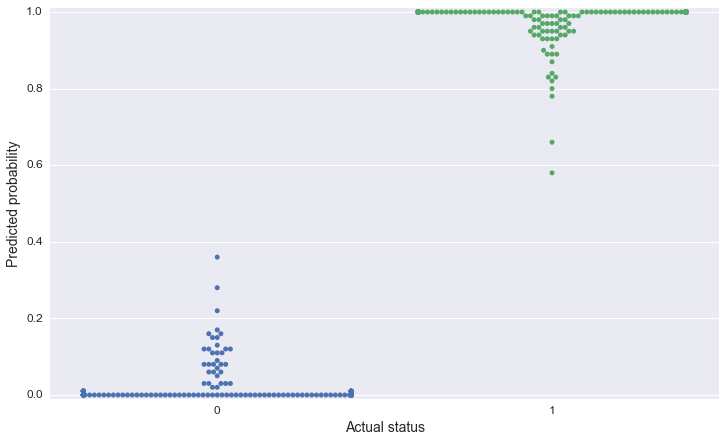

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(breast_cancer_data.drop('class', axis=1).values,
                                                    breast_cancer_data['class'].values,
                                                    stratify=breast_cancer_data['class'].values,
                                                    train_size=0.75, test_size=0.25)

clf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
clf.fit(X_train, y_train)

plt.figure(figsize=(12, 7))
sb.swarmplot(y_train, clf.predict(X_train))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Actual status', fontsize=14)
plt.ylabel('Predicted probability', fontsize=14)
plt.ylim(-0.01, 1.01)
;

### Testing data

''

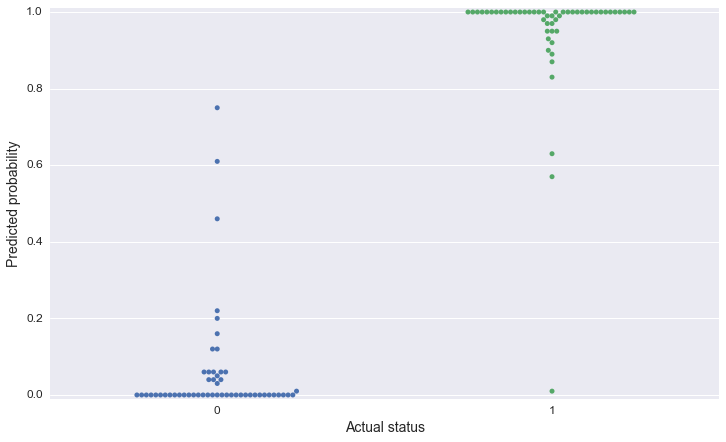

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(breast_cancer_data.drop('class', axis=1).values,
                                                    breast_cancer_data['class'].values,
                                                    stratify=breast_cancer_data['class'].values,
                                                    train_size=0.75, test_size=0.25)

clf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
clf.fit(X_train, y_train)

plt.figure(figsize=(12, 7))
sb.swarmplot(y_test, clf.predict(X_test))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Actual status', fontsize=14)
plt.ylabel('Predicted probability', fontsize=14)
plt.ylim(-0.01, 1.01)
;

## Crowd machine

1. Run random forest with 15 or 20 different terminal node sizes, on the same training data, in each case getting the probability for each subject or instance;
2. Use the output from each as a new synthetic feature, which is then input to another (single) random random forest, also run in regression mode; In this case the probability estimates from each synthetic feature will be sort of continuous as they are probability estimates and not just zero or one things;
3. Generate some simple plots for the crowd;
4. Compare the crowd results to some individual random forest runs, using some two or three terminal node settings.

In [12]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline, make_union
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import cross_val_score

breast_cancer_data = pd.read_csv('data/breast-cancer-wisconsin.tsv.gz',
                                 sep='\t',
                                 compression='gzip')

breast_cancer_data = pd.concat([breast_cancer_data.loc[
            np.random.choice(breast_cancer_data.loc[breast_cancer_data['class'] == 0].index.values, 212)],
                                breast_cancer_data.loc[breast_cancer_data['class'] == 1]])

shuffled_indices = breast_cancer_data.index.values
np.random.shuffle(shuffled_indices)
breast_cancer_data = breast_cancer_data.loc[shuffled_indices]

all_features = breast_cancer_data.drop('class', axis=1).values
all_classes = breast_cancer_data['class'].values

union_ops = [SelectKBest(k='all')]

for i, mwfl in enumerate(np.arange(0., 0.21, 0.01)):
    union_ops.append(VotingClassifier(estimators=[('rf-mwfl={}'.format(mwfl),
                                                   RandomForestRegressor(n_estimators=100,
                                                                         n_jobs=-1,
                                                                         min_weight_fraction_leaf=mwfl))]))
    
    clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, min_weight_fraction_leaf=mwfl)
    print('RF w/ mwfl={:0.2f} CV score: {:0.3f}'.format(
            mwfl,
            np.mean(cross_val_score(clf, all_features, all_classes, cv=10))))

clf = make_pipeline(make_union(*union_ops), RandomForestClassifier(n_estimators=100, n_jobs=-1))
print('Crowd machine CV score: {:0.3f}'.format(np.mean(cross_val_score(clf, all_features, all_classes, cv=10))))

RF w/ mwfl=0.00 CV score: 0.980
RF w/ mwfl=0.01 CV score: 0.980
RF w/ mwfl=0.02 CV score: 0.980
RF w/ mwfl=0.03 CV score: 0.968
RF w/ mwfl=0.04 CV score: 0.963
RF w/ mwfl=0.05 CV score: 0.957
RF w/ mwfl=0.06 CV score: 0.955
RF w/ mwfl=0.07 CV score: 0.950
RF w/ mwfl=0.08 CV score: 0.950
RF w/ mwfl=0.09 CV score: 0.953
RF w/ mwfl=0.10 CV score: 0.948
RF w/ mwfl=0.11 CV score: 0.948
RF w/ mwfl=0.12 CV score: 0.946
RF w/ mwfl=0.13 CV score: 0.944
RF w/ mwfl=0.14 CV score: 0.948
RF w/ mwfl=0.15 CV score: 0.946
RF w/ mwfl=0.16 CV score: 0.946
RF w/ mwfl=0.17 CV score: 0.944
RF w/ mwfl=0.18 CV score: 0.940
RF w/ mwfl=0.19 CV score: 0.944
RF w/ mwfl=0.20 CV score: 0.944
Crowd machine CV score: 0.981


# Spambase data set

In [6]:
import pandas as pd

spambase_data = pd.read_csv('http://www.randalolson.com/data/benchmarks/spambase.csv.gz',
                            sep='\t',
                            compression='gzip')

spambase_data = pd.concat([spambase_data.loc[
            np.random.choice(spambase_data.loc[spambase_data['class'] == 0].index.values, 1813)],
                                spambase_data.loc[spambase_data['class'] == 1]])

## Class frequencies

In [7]:
from collections import Counter

Counter(spambase_data['class'].values)

Counter({0: 1813, 1: 1813})

## Compute the cross-validation scores

Here, the scores are accuracy on the data set.

In [8]:
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier

cross_val_score(RandomForestClassifier(n_estimators=100, n_jobs=-1),
                spambase_data.drop('class', axis=1).values,
                spambase_data.loc[:, 'class'].values,
                cv=10)

array([ 0.95054945,  0.94230769,  0.93681319,  0.95856354,  0.96961326,
        0.97513812,  0.9640884 ,  0.96132597,  0.94198895,  0.91160221])

## Visualize the predictions vs. actual status

Each dot corresponds to one prediction.

### Training data

''

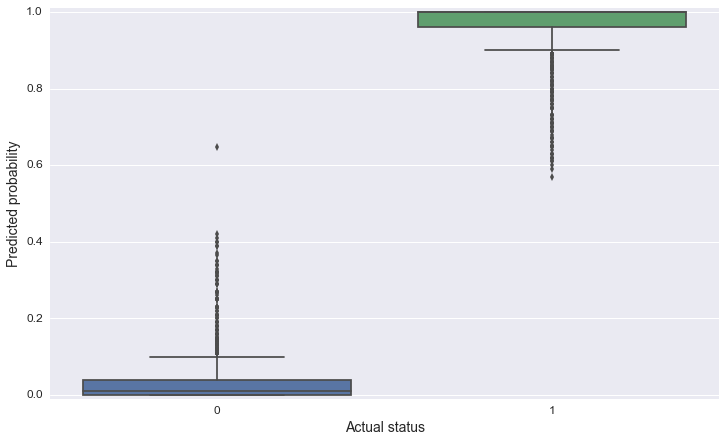

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(spambase_data.drop('class', axis=1).values,
                                                    spambase_data['class'].values,
                                                    stratify=spambase_data['class'].values,
                                                    train_size=0.75, test_size=0.25)

clf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
clf.fit(X_train, y_train)

plt.figure(figsize=(12, 7))
sb.boxplot(y_train, clf.predict(X_train))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Actual status', fontsize=14)
plt.ylabel('Predicted probability', fontsize=14)
plt.ylim(-0.01, 1.01)
;

### Testing data

''

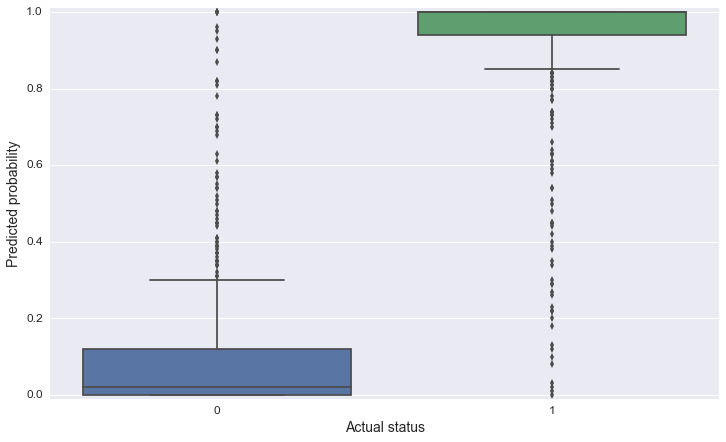

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(spambase_data.drop('class', axis=1).values,
                                                    spambase_data['class'].values,
                                                    stratify=spambase_data['class'].values,
                                                    train_size=0.75, test_size=0.25)

clf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
clf.fit(X_train, y_train)

plt.figure(figsize=(12, 7))
sb.boxplot(y_test, clf.predict(X_test))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Actual status', fontsize=14)
plt.ylabel('Predicted probability', fontsize=14)
plt.ylim(-0.01, 1.01)
;

## Crowd machine

1. Run random forest with 15 or 20 different terminal node sizes, on the same training data, in each case getting the probability for each subject or instance;
2. Use the output from each as a new synthetic feature, which is then input to another (single) random random forest, also run in regression mode; In this case the probability estimates from each synthetic feature will be sort of continuous as they are probability estimates and not just zero or one things;
3. Generate some simple plots for the crowd;
4. Compare the crowd results to some individual random forest runs, using some two or three terminal node settings.

In [92]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline, make_union
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import cross_val_score

spambase_data = pd.read_csv('http://www.randalolson.com/data/benchmarks/spambase.csv.gz',
                            sep='\t',
                            compression='gzip')

spambase_data = pd.concat([spambase_data.loc[
            np.random.choice(spambase_data.loc[spambase_data['class'] == 0].index.values, 1813)],
                                spambase_data.loc[spambase_data['class'] == 1]])

shuffled_indices = spambase_data.index.values
np.random.shuffle(shuffled_indices)
spambase_data = spambase_data.loc[shuffled_indices]

all_features = spambase_data.drop('class', axis=1).values
all_classes = spambase_data['class'].values

union_ops = [SelectKBest(k='all')]

for i, mwfl in enumerate(np.arange(0., 0.21, 0.01)):
    union_ops.append(VotingClassifier(estimators=[('rf-mwfl={}'.format(mwfl),
                                                   RandomForestRegressor(n_estimators=100,
                                                                         n_jobs=-1,
                                                                         min_weight_fraction_leaf=mwfl))]))
    
    clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, min_weight_fraction_leaf=mwfl)
    print('RF w/ mwfl={:0.2f} CV score: {:0.3f}'.format(
            mwfl,
            np.mean(cross_val_score(clf, all_features, all_classes, cv=3))))

clf = make_pipeline(make_union(*union_ops), RandomForestClassifier(n_estimators=100, n_jobs=-1))
print('Crowd machine CV score: {:0.3f}'.format(np.mean(cross_val_score(clf, all_features, all_classes, cv=3))))

RF w/ mwfl=0.00 CV score: 0.967
RF w/ mwfl=0.01 CV score: 0.933
RF w/ mwfl=0.02 CV score: 0.923
RF w/ mwfl=0.03 CV score: 0.918
RF w/ mwfl=0.04 CV score: 0.911
RF w/ mwfl=0.05 CV score: 0.907
RF w/ mwfl=0.06 CV score: 0.904
RF w/ mwfl=0.07 CV score: 0.904
RF w/ mwfl=0.08 CV score: 0.898
RF w/ mwfl=0.09 CV score: 0.904
RF w/ mwfl=0.10 CV score: 0.901
RF w/ mwfl=0.11 CV score: 0.896
RF w/ mwfl=0.12 CV score: 0.895
RF w/ mwfl=0.13 CV score: 0.898
RF w/ mwfl=0.14 CV score: 0.891
RF w/ mwfl=0.15 CV score: 0.893
RF w/ mwfl=0.16 CV score: 0.887
RF w/ mwfl=0.17 CV score: 0.887
RF w/ mwfl=0.18 CV score: 0.889
RF w/ mwfl=0.19 CV score: 0.883
RF w/ mwfl=0.20 CV score: 0.875
Crowd machine CV score: 0.959


# GAMETES data sets

## Crowd machine

1. Run random forest with 15 or 20 different terminal node sizes, on the same training data, in each case getting the probability for each subject or instance;
2. Use the output from each as a new synthetic feature, which is then input to another (single) random random forest, also run in regression mode; In this case the probability estimates from each synthetic feature will be sort of continuous as they are probability estimates and not just zero or one things;
3. Generate some simple plots for the crowd;
4. Compare the crowd results to some individual random forest runs, using some two or three terminal node settings.

In [58]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline, make_union
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import cross_val_score

gametes_data = pd.read_csv('data/GAMETES_Epistasis_2-Way_20atts_0.4H_EDM-1_1.tsv.gz',
                           sep='\t',
                           compression='gzip')

shuffled_indices = gametes_data.index.values
np.random.shuffle(shuffled_indices)
gametes_data = gametes_data.loc[shuffled_indices]

all_features = gametes_data.drop('class', axis=1).values
all_classes = gametes_data['class'].values

union_ops = [SelectKBest(k='all')]

for i, mwfl in enumerate(np.arange(0., 0.101, 0.005)):
    union_ops.append(VotingClassifier(estimators=[('rf-mwfl={}'.format(mwfl),
                                                   RandomForestRegressor(n_estimators=100,
                                                                         n_jobs=-1,
                                                                         min_weight_fraction_leaf=mwfl))]))

    clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, min_weight_fraction_leaf=mwfl)
    print('RF w/ mwfl={:0.3f} CV score: {:0.3f}'.format(
            mwfl,
            np.mean(cross_val_score(clf, all_features, all_classes, cv=10))))

clf = make_pipeline(make_union(*union_ops), RandomForestClassifier(n_estimators=100, n_jobs=-1))
print('Crowd machine CV score: {:0.3f}'.format(np.mean(cross_val_score(clf, all_features, all_classes, cv=10))))

RF w/ mwfl=0.000 CV score: 0.688
RF w/ mwfl=0.005 CV score: 0.694
RF w/ mwfl=0.010 CV score: 0.681
RF w/ mwfl=0.015 CV score: 0.674
RF w/ mwfl=0.020 CV score: 0.683
RF w/ mwfl=0.025 CV score: 0.673
RF w/ mwfl=0.030 CV score: 0.682
RF w/ mwfl=0.035 CV score: 0.653
RF w/ mwfl=0.040 CV score: 0.661
RF w/ mwfl=0.045 CV score: 0.650
RF w/ mwfl=0.050 CV score: 0.652
RF w/ mwfl=0.055 CV score: 0.628
RF w/ mwfl=0.060 CV score: 0.648
RF w/ mwfl=0.065 CV score: 0.633
RF w/ mwfl=0.070 CV score: 0.626
RF w/ mwfl=0.075 CV score: 0.600
RF w/ mwfl=0.080 CV score: 0.645
RF w/ mwfl=0.085 CV score: 0.628
RF w/ mwfl=0.090 CV score: 0.610
RF w/ mwfl=0.095 CV score: 0.620
RF w/ mwfl=0.100 CV score: 0.617
Crowd machine CV score: 0.709


In [59]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline, make_union
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import cross_val_score

gametes_data = pd.read_csv('data/GAMETES_Epistasis_2-Way_20atts_0.1H_EDM-1_1.tsv.gz',
                           sep='\t',
                           compression='gzip')

shuffled_indices = gametes_data.index.values
np.random.shuffle(shuffled_indices)
gametes_data = gametes_data.loc[shuffled_indices]

all_features = gametes_data.drop('class', axis=1).values
all_classes = gametes_data['class'].values

union_ops = [SelectKBest(k='all')]

for i, mwfl in enumerate(np.arange(0., 0.101, 0.005)):
    union_ops.append(VotingClassifier(estimators=[('rf-mwfl={}'.format(mwfl),
                                                   RandomForestRegressor(n_estimators=100,
                                                                         n_jobs=-1,
                                                                         min_weight_fraction_leaf=mwfl))]))
    
    clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, min_weight_fraction_leaf=mwfl)
    print('RF w/ mwfl={:0.3f} CV score: {:0.3f}'.format(
            mwfl,
            np.mean(cross_val_score(clf, all_features, all_classes, cv=10))))

clf = make_pipeline(make_union(*union_ops), RandomForestClassifier(n_estimators=100, n_jobs=-1))
print('Crowd machine CV score: {:0.3f}'.format(np.mean(cross_val_score(clf, all_features, all_classes, cv=10))))

RF w/ mwfl=0.000 CV score: 0.568
RF w/ mwfl=0.005 CV score: 0.566
RF w/ mwfl=0.010 CV score: 0.574
RF w/ mwfl=0.015 CV score: 0.571
RF w/ mwfl=0.020 CV score: 0.564
RF w/ mwfl=0.025 CV score: 0.557
RF w/ mwfl=0.030 CV score: 0.581
RF w/ mwfl=0.035 CV score: 0.566
RF w/ mwfl=0.040 CV score: 0.548
RF w/ mwfl=0.045 CV score: 0.554
RF w/ mwfl=0.050 CV score: 0.565
RF w/ mwfl=0.055 CV score: 0.559
RF w/ mwfl=0.060 CV score: 0.546
RF w/ mwfl=0.065 CV score: 0.547
RF w/ mwfl=0.070 CV score: 0.551
RF w/ mwfl=0.075 CV score: 0.530
RF w/ mwfl=0.080 CV score: 0.538
RF w/ mwfl=0.085 CV score: 0.551
RF w/ mwfl=0.090 CV score: 0.537
RF w/ mwfl=0.095 CV score: 0.541
RF w/ mwfl=0.100 CV score: 0.539
Crowd machine CV score: 0.590


In [60]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline, make_union
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import cross_val_score

gametes_data = pd.read_csv('data/GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_EDM-1_1.tsv.gz',
                           sep='\t',
                           compression='gzip')

shuffled_indices = gametes_data.index.values
np.random.shuffle(shuffled_indices)
gametes_data = gametes_data.loc[shuffled_indices]

all_features = gametes_data.drop('class', axis=1).values
all_classes = gametes_data['class'].values

union_ops = [SelectKBest(k='all')]

for i, mwfl in enumerate(np.arange(0., 0.101, 0.005)):
    union_ops.append(VotingClassifier(estimators=[('rf-mwfl={}'.format(mwfl),
                                                   RandomForestRegressor(n_estimators=100,
                                                                         n_jobs=-1,
                                                                         min_weight_fraction_leaf=mwfl))]))
    
    clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, min_weight_fraction_leaf=mwfl)
    print('RF w/ mwfl={:0.3f} CV score: {:0.3f}'.format(
            mwfl,
            np.mean(cross_val_score(clf, all_features, all_classes, cv=10))))

clf = make_pipeline(make_union(*union_ops), RandomForestClassifier(n_estimators=100, n_jobs=-1))
print('Crowd machine CV score: {:0.3f}'.format(np.mean(cross_val_score(clf, all_features, all_classes, cv=10))))

RF w/ mwfl=0.000 CV score: 0.507
RF w/ mwfl=0.005 CV score: 0.490
RF w/ mwfl=0.010 CV score: 0.483
RF w/ mwfl=0.015 CV score: 0.505
RF w/ mwfl=0.020 CV score: 0.483
RF w/ mwfl=0.025 CV score: 0.497
RF w/ mwfl=0.030 CV score: 0.484
RF w/ mwfl=0.035 CV score: 0.477
RF w/ mwfl=0.040 CV score: 0.488
RF w/ mwfl=0.045 CV score: 0.507
RF w/ mwfl=0.050 CV score: 0.472
RF w/ mwfl=0.055 CV score: 0.483
RF w/ mwfl=0.060 CV score: 0.487
RF w/ mwfl=0.065 CV score: 0.496
RF w/ mwfl=0.070 CV score: 0.466
RF w/ mwfl=0.075 CV score: 0.477
RF w/ mwfl=0.080 CV score: 0.492
RF w/ mwfl=0.085 CV score: 0.490
RF w/ mwfl=0.090 CV score: 0.466
RF w/ mwfl=0.095 CV score: 0.469
RF w/ mwfl=0.100 CV score: 0.459
Crowd machine CV score: 0.486


In [61]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline, make_union
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import cross_val_score

gametes_data = pd.read_csv('data/GAMETES_Epistasis_3-Way_20atts_0.2H_EDM-1_1.tsv.gz',
                           sep='\t',
                           compression='gzip')

shuffled_indices = gametes_data.index.values
np.random.shuffle(shuffled_indices)
gametes_data = gametes_data.loc[shuffled_indices]

all_features = gametes_data.drop('class', axis=1).values
all_classes = gametes_data['class'].values

union_ops = [SelectKBest(k='all')]

for i, mwfl in enumerate(np.arange(0., 0.101, 0.005)):
    union_ops.append(VotingClassifier(estimators=[('rf-mwfl={}'.format(mwfl),
                                                   RandomForestRegressor(n_estimators=100,
                                                                         n_jobs=-1,
                                                                         min_weight_fraction_leaf=mwfl))]))
    
    clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, min_weight_fraction_leaf=mwfl)
    print('RF w/ mwfl={:0.3f} CV score: {:0.3f}'.format(
            mwfl,
            np.mean(cross_val_score(clf, all_features, all_classes, cv=10))))

clf = make_pipeline(make_union(*union_ops), RandomForestClassifier(n_estimators=100, n_jobs=-1))
print('Crowd machine CV score: {:0.3f}'.format(np.mean(cross_val_score(clf, all_features, all_classes, cv=10))))

RF w/ mwfl=0.000 CV score: 0.561
RF w/ mwfl=0.005 CV score: 0.542
RF w/ mwfl=0.010 CV score: 0.531
RF w/ mwfl=0.015 CV score: 0.533
RF w/ mwfl=0.020 CV score: 0.537
RF w/ mwfl=0.025 CV score: 0.537
RF w/ mwfl=0.030 CV score: 0.532
RF w/ mwfl=0.035 CV score: 0.519
RF w/ mwfl=0.040 CV score: 0.523
RF w/ mwfl=0.045 CV score: 0.527
RF w/ mwfl=0.050 CV score: 0.529
RF w/ mwfl=0.055 CV score: 0.526
RF w/ mwfl=0.060 CV score: 0.517
RF w/ mwfl=0.065 CV score: 0.517
RF w/ mwfl=0.070 CV score: 0.527
RF w/ mwfl=0.075 CV score: 0.516
RF w/ mwfl=0.080 CV score: 0.523
RF w/ mwfl=0.085 CV score: 0.519
RF w/ mwfl=0.090 CV score: 0.521
RF w/ mwfl=0.095 CV score: 0.507
RF w/ mwfl=0.100 CV score: 0.516
Crowd machine CV score: 0.593
